# A/B-тестирование: увеличение чувствительности метрики 

<div style="border:solid black 1.5px; padding: 20px">

**Заказчик** - Команда ML

---

**Об исследовании:**

Команда ML разработала 2 новых алгоритма рекомендаций в новостной ленте приложения. Суть алгоритмов заключается в следующем:

> _В новостной ленте будут появляться посты, схожие на те, что пользователь оценил ранее_
    
    Тестирование алгоритма проходит на группах 0 и 3, где:
    
    0 - это контрольная группа
    3 - это эксперементальная группа
    
> _В новостной ленте будут появляться посты, которые оценили (лайкнули) похожие на пользователя посетители_
    
    Тестирование алгоритма проходит на группах 1 и 2, где:
    
    1 - это контрольная группа
    2 - это эксперементальная группа

---
    
*_Даты проведенных тестов:_*

>- А/А тест проводился с '2023-05-24' по '2023-05-30'.
>- А/В тест проводился с '2023-05-31' по '2023-06-06'.

---

**Цель исследования:**

Постараться увеличить чувствительность метрики: 

---

**Задачи исследования:**

>- Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Ответить на вопросы: 
    
        1. Видно ли отличие? 
        2. Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
    
>- Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Ответить на вопросы: 
    
        1. Видно ли отличие? 
        2. Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

## Импорт библиотек и настройка тетради

In [1]:
# импорт необходимых библиотек
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import io
sns.set(style ='ticks')
import numpy as np
from scipy import stats as st
import math as mth
from math import factorial
import statsmodels.api as sm 
from read_db.CH import Getch
import pandahouse as ph

In [2]:
# настройка тетради
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

# помощь в отображении данных
pd.set_option('display.max_columns', None) # отображение всех столбцов
pd.set_option('display.max_colwidth', None) # отображение данных в столбцах, даже если они слишком длинные

## Формирование датасетов для анализа

In [3]:
# подключение к базе даных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
# извлечение данных для первой задачи (группы 0 и 3)
query = '''
    SELECT exp_group, 
           user_id,
           sum(action = 'like') likes,
           sum(action = 'view') views,
           likes/views as ctr 
    FROM simulator_20230620.feed_actions 
    WHERE toDate(time) between '2023-05-31' and '2023-06-06'
          and exp_group in (0, 3)
    GROUP BY exp_group, user_id
'''

df_03 = ph.read_clickhouse(query, connection=connection)
df_03.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [5]:
#извлекаем данные для второй задачи (группы 1 и 2)
query = '''
    SELECT exp_group, 
           user_id,
           sum(action = 'like') likes,
           sum(action = 'view') views,
           likes/views as ctr 
    FROM simulator_20230620.feed_actions 
    WHERE toDate(time) between '2023-05-31' and '2023-06-06'
          and exp_group in (1, 2)
    GROUP BY exp_group, user_id
'''

df_12 = ph.read_clickhouse(query, connection=connection)
df_12.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


## Тест между группами 0 и 3 по метрике линеаризованных лайков

Немного ясности и пояснений по методу, используемому в данной работе.

Идея метода заключается в следующем:

>- Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе  

𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

- Посчитаем в обеих группах поюзерную метрику 

𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠


- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  



---

_Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже)._ 

---

Сразу же обозначим гипотезы:

**По CTR**

Н₀(нулевая гипотеза) - это предположение о том, средняя величина CTR в группах _не имеет_ статистически значимых различий.

Н1₁(альтернативная гипотеза) - это предположение о том, средняя величина CTR в группах _имеет_ статистически значимые различия.

**По линеаризованным лайкам**

Н₀(нулевая гипотеза) - это предположение о том, средняя величина 'linearized_likes' в группах _не имеет_ статистически значимых различий.

Н1₁(альтернативная гипотеза) - это предположение о том, средняя величина 'linearized_likes' в группах _имеет_ статистически значимые различия.

Начнем с того, что посчитаем CTR в контрольной группе. Напомню информацию по группам:
- 0 и 1 - контрольные группы пользователей, не столкнувшиеся с изменениями в ленте
- 2 и 3 - группы, на пользователей из которых были раскатаны новые алгоритмы рекомендаций

In [6]:
# CTR контрольной группы 0
ctr_1 = df_03[df_03.exp_group == 0].likes.sum() / df_03[df_03.exp_group == 0].views.sum()

print('Общегрупповой CTR в контрольной группе 0 равен', ctr_1)

Общегрупповой CTR в контрольной группе 0 равен 0.20823612262916305


Далее, согласно данным выше инструкциям, нам необходимо посчитать поюзерную метрику '𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠' для обеих групп - 0 и 3.

In [7]:
# расчет 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 для групп 0 и 3
df_03['linearized_likes'] = df_03.likes - (ctr_1 * df_03.views)

df_03.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666
2,0,4944,8,41,0.195122,-0.537681
3,0,4504,5,15,0.333333,1.876458
4,0,121508,18,88,0.204545,-0.324779


Посмотрим графически как распределены наши метрики.

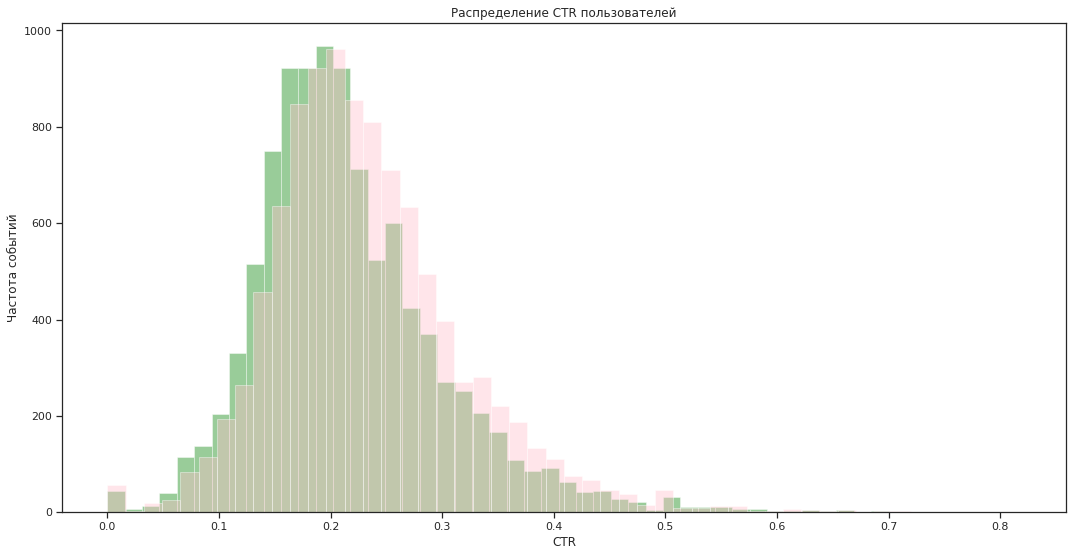

In [8]:
plt.figure(figsize=(18,9))

sns.distplot(df_03[df_03.exp_group == 0].ctr, kde = False, color = 'green')
sns.distplot(df_03[df_03.exp_group == 3].ctr, kde = False, color = 'pink')
plt.title('Распределение CTR пользователей')
plt.xlabel('CTR')
plt.ylabel('Частота событий');

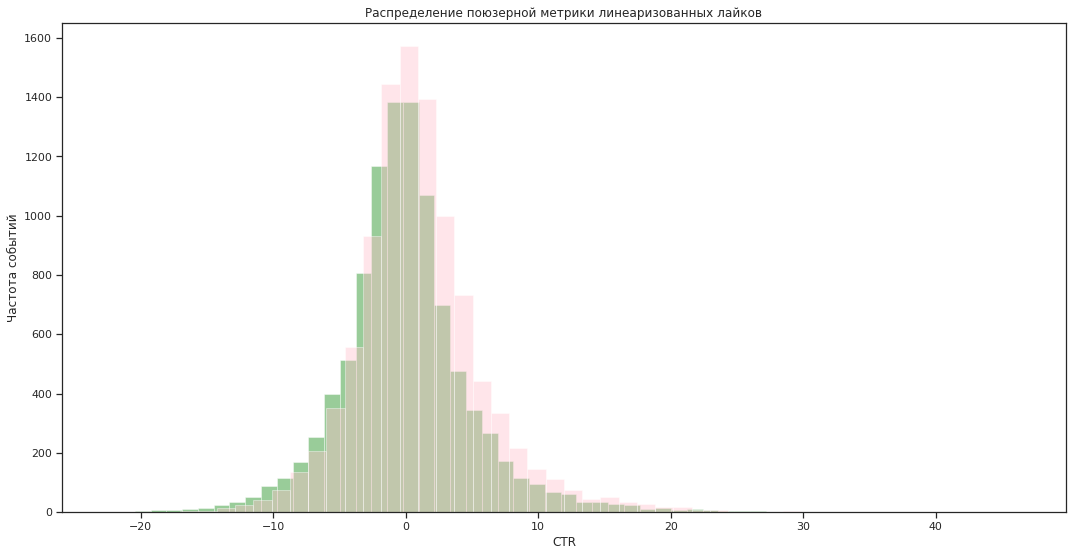

In [9]:
plt.figure(figsize=(18,9))

sns.distplot(df_03[df_03.exp_group == 0].linearized_likes, kde = False, color = 'green')
sns.distplot(df_03[df_03.exp_group == 3].linearized_likes, kde = False, color = 'pink')
plt.title('Распределение поюзерной метрики линеаризованных лайков')
plt.xlabel('CTR')
plt.ylabel('Частота событий');

Проведем два t-теста:
1. на поюзерном CTR
2. на поюзерной метрике linearized_likes (линеаризованные лайки)

Это необходимо для того, чтобы сравнить две величины p-valeu и определить есть ли отличия.

In [10]:
# t-test для CTR
alpha = .05 # критические уровень значимости

results = st.ttest_ind(df_03[df_03.exp_group == 0].ctr,
            df_03[df_03.exp_group == 3].ctr,
            equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.055849414662529e-43
Отвергаем нулевую гипотезу


In [11]:
# t-test для linearized_likes

alpha = .05 # критические уровень значимости

results = st.ttest_ind(df_03[df_03.exp_group == 0].linearized_likes,
            df_03[df_03.exp_group == 3].linearized_likes,
            equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.4914249479690016e-52
Отвергаем нулевую гипотезу


<div style="border:solid black 0.5px; padding: 20px">

**Выводы по этапу:**

- Оба теста показали наличие статистически значимой разнизы между выборками.
- Во втором случае значение p-valeu ниже, что говорит о большей чувствительности тесты. Как мы помним, чем ниже значение p-valeu, тем лучше, поскольку при этом увеличивается «сила» отклонения нулевой гипотезы и увеличивается ожидаемая значимость результата.
- Согласно гистограммам распределения показатели немного выше у эксперементальной группы (на группу 3 был раскатан алгоритм рекомендаций, где пользователю предлагали посты на основании тех, что он оценил ранее).

## Тест между группами 1 и 2 по метрике линеаризованных лайков

Вспомним о каких изменениях идет речь. Данные группы участвовали в тесте по новому алгоритму рекоментаций - В новостной ленте будут появляться посты, которые оценили (лайкнули) похожие на пользователя посетители.

- Группа 1 - контрольная
- Группа 2 - эксперементальная

Ранее, в предыдущих исследованиях, было определено, что поведение пользователей во второй группе имеет странное различие - вероятно кому-то новый алгоритм не понравится, а кому-то наоборот. Это предположение было выстроено на двухмодальном распределении CTR.

Проверим как сработает тест по метрике линеаризованных лайков.

---

Обозначим гипотезы:

**По CTR**

Н₀(нулевая гипотеза) - это предположение о том, средняя величина CTR в группах _не имеет_ статистически значимых различий.

Н1₁(альтернативная гипотеза) - это предположение о том, средняя величина CTR в группах _имеет_ статистически значимые различия.

**По линеаризованным лайкам**

Н₀(нулевая гипотеза) - это предположение о том, средняя величина 'linearized_likes' в группах _не имеет_ статистически значимых различий.

Н1₁(альтернативная гипотеза) - это предположение о том, средняя величина 'linearized_likes' в группах _имеет_ статистически значимые различия.

In [12]:
# CTR контрольной группы 1
ctr_2 = df_12[df_12.exp_group == 1].likes.sum() / df_12[df_12.exp_group == 1].views.sum()

print('Общегрупповой CTR в контрольной группе 1 равен', ctr_2)

Общегрупповой CTR в контрольной группе 1 равен 0.20802680490126244


In [13]:
# расчет 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 для групп 1 и 2
df_12['linearized_likes'] = df_12.likes - (ctr_2 * df_12.views)

df_12.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,109963,3,15,0.200000,-0.120402
1,1,26117,32,141,0.226950,2.668221
2,1,138232,18,73,0.246575,2.814043
3,1,26295,33,122,0.270492,7.620730
4,1,18392,7,32,0.218750,0.343142


Посмотрим на графическое распределение метрик.

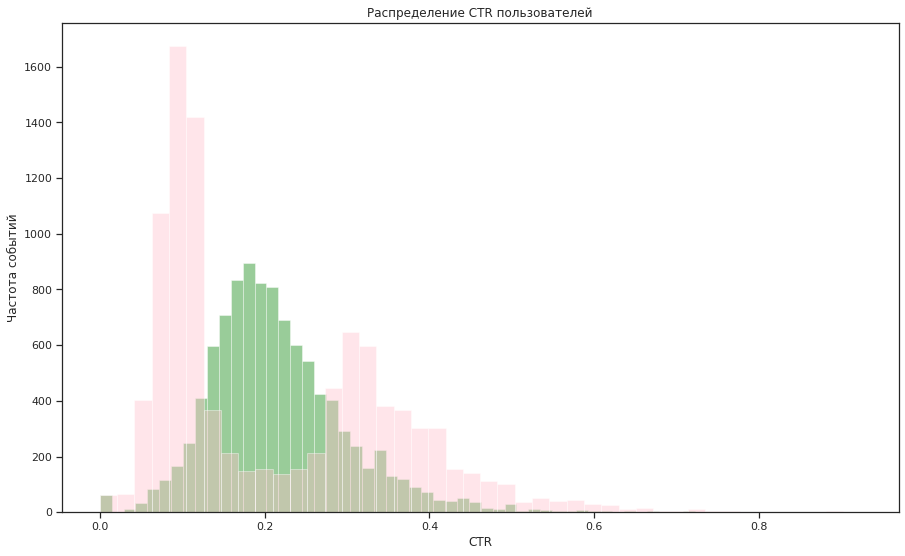

In [14]:
plt.figure(figsize=(15,9))

sns.distplot(df_12[df_12.exp_group == 1].ctr, kde = False, color = 'green')
sns.distplot(df_12[df_12.exp_group == 2].ctr, kde = False, color = 'pink')
plt.title('Распределение CTR пользователей')
plt.xlabel('CTR')
plt.ylabel('Частота событий');

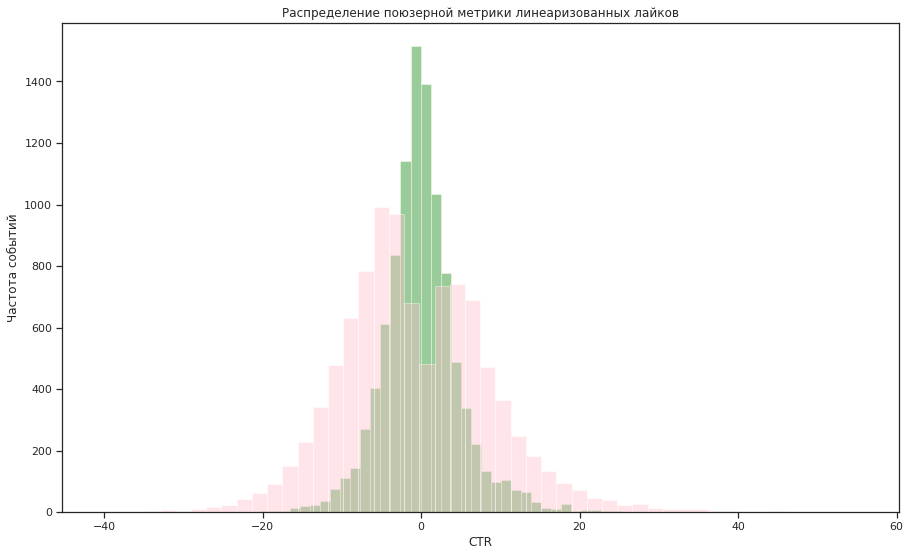

In [15]:
plt.figure(figsize=(15,9))

sns.distplot(df_12[df_12.exp_group == 1].linearized_likes, kde = False, color = 'green')
sns.distplot(df_12[df_12.exp_group == 2].linearized_likes, kde = False, color = 'pink')
plt.title('Распределение поюзерной метрики линеаризованных лайков')
plt.xlabel('CTR')
plt.ylabel('Частота событий');

Что примечательно, распределение линеаризованных лайков в экспеперементальной группе также двухмодально. Об этом надо помнить, при выполнении t-теста - распределение не нормально.

In [16]:
# t-test для CTR
alpha = .05 # критические уровень значимости

results = st.ttest_ind(df_12[df_12.exp_group == 1].ctr,
            df_12[df_12.exp_group == 2].ctr,
            equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.47806231308750413
Не получилось отвергнуть нулевую гипотезу


In [17]:
# t-test для linearized_likes

alpha = .05 # критические уровень значимости

results = st.ttest_ind(df_12[df_12.exp_group == 1].linearized_likes,
            df_12[df_12.exp_group == 2].linearized_likes,
            equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 9.439432187037712e-10
Отвергаем нулевую гипотезу


<div style="border:solid black 0.5px; padding: 20px">

**Вывод по этапу**

- Что примечательно, t-тест на выборке CTR не показал статистически значимых различий, а вот по метрике линеаризованных лайков статистически значимое различие было определено, что позволило опровергнуть нулевоую гипотезу о равенстве средних.
- Значение p-valeu для метрики линеаризованных лайков тоже снизилось, при чем значительно.      
- Результаты проведенных тестов говорят нам о том, что метод, где мы конструируем новую метрику (в данном случае линеаризованные лайки), более чувствителен и позволяет нам с большей точностью определить различия выборок.

# Вывод по работе

<div style="border:solid black 0.5px; padding: 20px">

По результатам исследования можно сделать вывод, что с высокой долей вероятности, метод конструирования другой метрики и ее анализ позволяет увеличить чувствительность проводимого теста.